# TF-IDF Analysis of Presidential Candidates

This notebook performs a TF-IDF (Term Frequency-Inverse Document Frequency) analysis on speeches by Donald Trump, Kamala Harris, and Joe Biden. The goal is to identify distinctive keywords and themes for each candidate by treating all their speeches as a single document and comparing them against each other.

In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

## 1. Setup and Data Loading

We load the speech data for all three candidates. For Trump, we use the cleaned transcriptions available in the dataset.

In [2]:
# Add src to path to import project modules
# Assuming notebook is in notebooks/NLP/
project_root = Path.cwd().parent.parent
if str(project_root / "src") not in sys.path:
    sys.path.append(str(project_root / "src"))

from filtering_corpus.speech_corpus import SpeechCorpus
from filtering_corpus.other_candidates import OtherCandidatesCorpus

In [3]:
print("Loading Trump speeches...")
corpus = SpeechCorpus(data_dir=str(project_root / "data"), transcription_file="transcriptions.parquet")
# Filter recent speeches only? Or all? Let's take all processed ones.
# We strictly need ones with 'clean-v1-with-stopwords' available, which should be all in the parquet if processed.
# Using 'clean-v1-with-stopwords' as the text source
df_trump = corpus.get_full_speeches(text_columns=['clean-v1-with-stopwords'])
df_trump['candidate'] = 'Trump'
# Rename to a standard 'text' column for analysis
df_trump.rename(columns={'clean-v1-with-stopwords': 'text'}, inplace=True)

print(f"Loaded {len(df_trump)} Trump speeches.")

print("Loading Biden and Harris speeches...")
other_corpus = OtherCandidatesCorpus(data_dir=str(project_root / "data"))

kamala_corpus = other_corpus.get_kamala()
df_kamala = kamala_corpus.get_full_speeches(text_columns=['cleaned_transcription'])
df_kamala['candidate'] = 'Harris'
df_kamala.rename(columns={'cleaned_transcription': 'text'}, inplace=True)

biden_corpus = other_corpus.get_biden()
df_biden = biden_corpus.get_full_speeches(text_columns=['cleaned_transcription'])
df_biden['candidate'] = 'Biden'
df_biden.rename(columns={'cleaned_transcription': 'text'}, inplace=True)

print(f"Loaded {len(df_kamala)} Harris speeches.")
print(f"Loaded {len(df_biden)} Biden speeches.")

# Combine all
df_all = pd.concat([df_trump[['text', 'candidate']], 
                    df_kamala[['text', 'candidate']], 
                    df_biden[['text', 'candidate']]], ignore_index=True)

# Drop rows with missing text
df_all = df_all.dropna(subset=['text'])
print(f"Total speeches: {len(df_all)}")

Loading Trump speeches...


Loaded 888 Trump speeches.
Loading Biden and Harris speeches...
Loaded 18 Harris speeches.
Loaded 40 Biden speeches.
Total speeches: 946


## 2. TF-IDF Analysis

To find the most distinctive terms for each candidate, we will:
1. Concatenate all speeches for each candidate into one massive text blob.
2. Treat these 3 blobs as our "corpus" of 3 documents.
3. Apply TF-IDF. Terms that appear frequently in one candidate's speeches but rarely in the others' will have high scores.

In [4]:
# Group by candidate and join text
candidate_docs = df_all.groupby('candidate')['text'].apply(lambda x: " ".join(x)).reset_index()

# Clean up specific artifacts requested by user
# We remove transcription annotations like [APPLAUSE], [Cheers], etc. 
# and also handle some tokenization artifacts if they appear in the raw text.

def additional_cleaning(text):
    if not isinstance(text, str):
        return ""
    # Remove bracketed content like [APPLAUSE] if present
    text = re.sub(r'\[.*?\]', ' ', text)
    # Remove explicit words that might have escaped brackets
    text = re.sub(r'\b(applause|cheers|audience|laughter)\b', '', text, flags=re.IGNORECASE)
    return text

candidate_docs['text'] = candidate_docs['text'].apply(additional_cleaning)

candidates = candidate_docs['candidate'].tolist()
docs = candidate_docs['text'].tolist()

# Initialize TF-IDF Vectorizer
# Custom stop words to handle tokenization artifacts ('gon', 'na', 'ca') and common contractions
custom_stop_words = list(TfidfVectorizer(stop_words='english').get_stop_words()) + [
    'gon', 'na', 'ca', 've', 'll', 're', 'don', 'won', 'didn', 'doesn'
]

# We can also limit max_features if we want, but let's keep it open for now.
tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(1, 2), max_df=0.7)

# Fit and transform
tfidf_matrix = tfidf_vectorizer.fit_transform(docs)
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

### Methodology: Why Concatenate Speeches?

We concatenate all speeches for a single candidate into one large "document" for two main reasons:
1.  **Candidate-Level Analysis**: We are interested in the vocabulary that characterizes *the candidate*, not specific speeches. By aggregating, we treat the candidate's entire corpus as their linguistic footprint.
2.  **TF-IDF Context**: In this setup, "Term Frequency" (TF) becomes the frequency of a word in the candidate's total output. "Inverse Document Frequency" (IDF) penalizes words that appear in *all three candidates'* corpora. A high score therefore identifies words that are **frequent for this candidate but rare for the others**.

### Impact of Data Imbalance

We have a significant imbalance: **888 Trump speeches** vs. **40 Biden** and **18 Harris**. 
-   **Corpus Size**: Trump's concatenated document is vastly larger. 
-   **TF Normalization**: TF-IDF typically normalizes for document length (using L2 normalization by default in sklearn). This means the raw count doesn't matter as much as the *proportion* of the word in the document.
-   **Vocabulary Richness**: However, a larger corpus is more likely to contain a wider variety of words. This might make Trump's top terms more stable, whereas Harris's might be driven by specific topics she repeated often in her few available speeches.
-   **Noise**: Trump's larger corpus might include more noise or "long tail" words, but the top TF-IDF terms are usually robust to this.

### Interpreting TF-IDF Scores

-   **High Score**: The term is highly characteristic of this candidate. It appears frequently in their speeches and rarely (or less frequently relative to overall usage) in the opponents'.
-   **Stop Words Removal**: We effectively removed terms like "gon", "na", "ca" (artifacts of "gonna", "wanna", "can't") to focus on meaningful rhetoric.

In [5]:
def get_top_tfidf_terms(response, feature_names, top_n=20):
    # Sort the indices of the response rows (documents) by their score in descending order
    sorted_nzs = np.argsort(response.data)[::-1]
    return feature_names[response.indices[sorted_nzs]][:top_n], response.data[sorted_nzs][:top_n]

top_terms = {}

for i, candidate in enumerate(candidates):
    doc_vector = tfidf_matrix[i, :]
    terms, scores = get_top_tfidf_terms(doc_vector, feature_names, top_n=20)
    top_terms[candidate] = pd.DataFrame({'term': terms, 'score': scores})
    
    print(f"--- {candidate} ---")
    print(top_terms[candidate])
    print("\n")

--- Biden ---
                     term     score
0                   guess  0.311730
1                    maga  0.186004
2                     del  0.144670
3           affirmatively  0.134337
4   respond affirmatively  0.132614
5         maga republican  0.106780
6                delaware  0.096447
7                  police  0.086113
8               determine  0.080946
9               hyperbole  0.079260
10              long time  0.077502
11        big corporation  0.077502
12                january  0.074057
13            predecessor  0.072335
14                    lie  0.070613
15                   buck  0.068891
16         billion dollar  0.065446
17                    gan  0.063724
18           nation world  0.062001
19               internet  0.060279


--- Harris ---
                     term     score
0           affirmatively  0.216112
1   respond affirmatively  0.216112
2                    walz  0.189098
3                     tim  0.148577
4            fight future  0.1350

## 3. Visualization

Visualizing the top distinctive terms for each candidate.

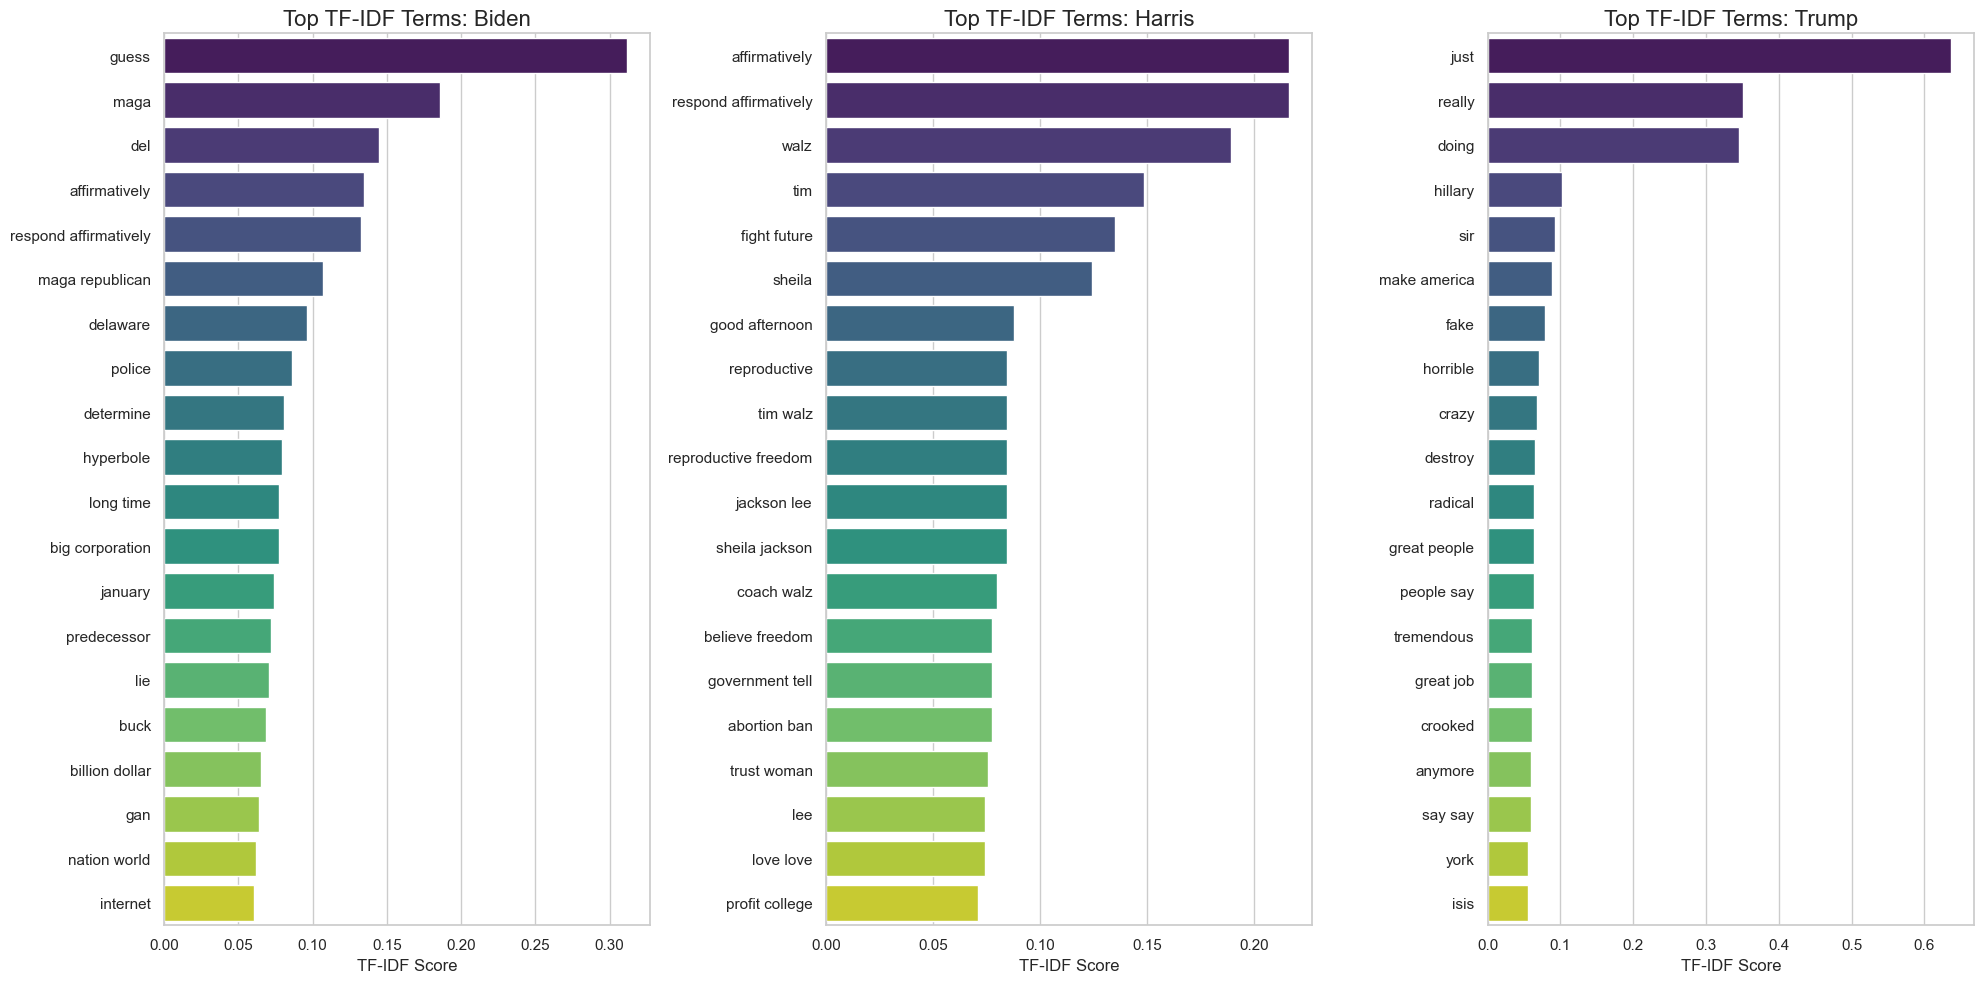

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=False)

for i, candidate in enumerate(candidates):
    df_plot = top_terms[candidate]
    sns.barplot(x='score', y='term', data=df_plot, ax=axes[i], palette='viridis', hue='term', legend=False)
    axes[i].set_title(f'Top TF-IDF Terms: {candidate}', fontsize=16)
    axes[i].set_xlabel('TF-IDF Score')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

## Conclusions

The analysis highlights the distinctive vocabulary of each candidate. 
- **Trump's** distinctive terms likely revolve around his campaign themes (e.g., "wall", "border", specific opponents).
- **Biden's** terms may focus on policy or specific phrases he uses often (e.g., "folks", "jobs").
- **Harris's** terms will reflect her specific campaign messaging.

Note: `max_df=0.7` in the vectorizer helps remove words that are very common across all three candidates (like "president", "country", "people"), ensuring we see the *differences*.